In [1]:
import sys
sys.path.append("../../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [2]:
# hand-compiled
def load_data(file_path):
    data = {f"{i:04b}": [] for i in range(16)}
    with open(file_path, 'r') as fp:
        lines = fp.readlines()

    for line in lines:
        if not line:
            continue
        l = line.strip().lstrip('[').rstrip(']')
        for l, v in zip(data.values(), l.split(',')):
            l.append(float(v.strip(' ')))

    return data

jaqal_results = load_data('./exp_data.txt')
jaqal_results = pd.DataFrame(jaqal_results)

In [3]:
# SUPERSTAQ RAW
run1 = np.load('./superstaq 2000 shots/Experiment Probabilities_1.npy', allow_pickle=True) 
run2 = np.load('./superstaq 2000 shots/Experiment Probabilities_2.npy', allow_pickle=True)
run3 = np.load('./superstaq 2000 shots/Experiment Probabilities_3.npy', allow_pickle=True)

lines = []
for timestep in zip(run1, run2, run3):
    timestep_data = {key: _ for key in timestep[0].keys()}
    for key, _ in timestep_data.items():
        timestep_data[key] = (np.mean([timestep[0][key], timestep[1][key], timestep[2][key]]))
    lines.append(timestep_data)
    
superstaq_results = pd.DataFrame(lines)

In [4]:
# mirror swaps, 3 runs of 2000 shots
run1 = np.load('./mirror_swaps/Experiment Probabilities.npy', allow_pickle=True) 
run2 = np.load('./mirror_swaps/Experiment Probabilities (1).npy', allow_pickle=True)
run3 = np.load('./mirror_swaps/Experiment Probabilities (2).npy', allow_pickle=True)

lines = []
for timestep in zip(run1, run2, run3):
    timestep_data = {key: _ for key in timestep[0].keys()}
    for key, _ in timestep_data.items():
        timestep_data[key] = (np.mean([timestep[0][key], timestep[1][key], timestep[2][key]]))
    lines.append(timestep_data)
    
mirror_results = pd.DataFrame(lines)

mirror_results.loc[10:, ['1000', '0001']] = mirror_results.loc[10:, ['0001', '1000']].values

# qutip simulation

In [5]:
N = 3
g = 2
kappa = 5
times = np.linspace(0, 3, 51)

In [6]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)
qutip_results["Emitter 2 and 3"] = qutip_results["Emitter 2"]

In [7]:
rms = {
    "jaqal": {},
    "jaqal normed": {},
    "superstaq": {},
    "superstaq normed": {},
    "mirror swaps": {},
    "mirror swaps normed": {},
}

mae = {
    "jaqal": {},
    "jaqal normed": {},
    "superstaq": {},
    "superstaq normed": {},
    "mirror swaps": {},
    "mirror swaps normed": {},
}

# JAQAL hand compiled

In [8]:
jaqal_bitstrs = {
    "Emitter 1": "0010",
    "Emitter 2": "0100",
    "Emitter 3": "1000",
    "Cavity + Environment": "0001",
}

Emitter 1 RMS 0.9646333402506285
Emitter 2 RMS 0.12868259920681202
Emitter 3 RMS 0.481097237818942
Cavity + Environment RMS 1.361409947293122


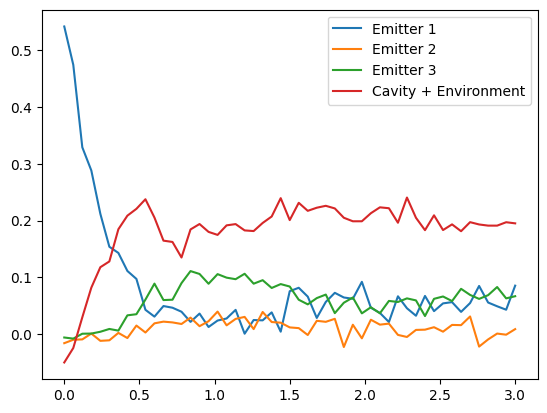

In [9]:
for col, bitstr in jaqal_bitstrs.items():
    diff = qutip_results[col] - np.array(jaqal_results[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms["jaqal"][col] = np.sqrt(np.sum(diff**2))
    mae["jaqal"][col] = np.mean(np.abs(diff))
    plt.plot(times, diff, label=col)


em23_mean = 0.5 * (np.array(jaqal_results[jaqal_bitstrs["Emitter 2"]]) + np.array(jaqal_results[jaqal_bitstrs["Emitter 3"]]))
diff = qutip_results[col] - em23_mean
jaqal_23_mean_mae = np.mean(np.abs(diff))

plt.legend()

## fourier

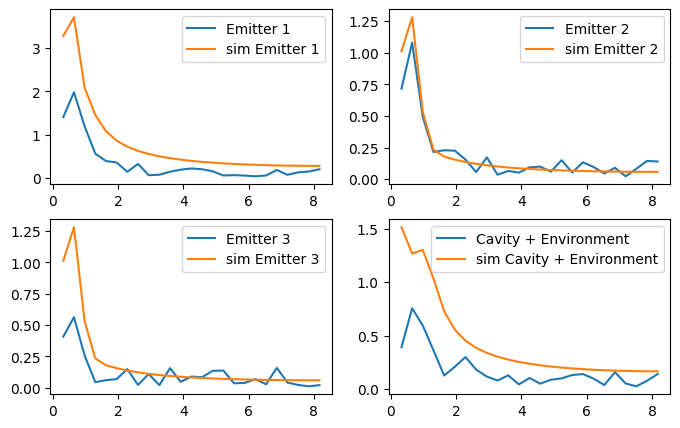

In [10]:
n = len(jaqal_results)
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

for (col, bitstr), ax in zip(jaqal_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(jaqal_results[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label="sim " + col)

    ax.legend()

## normed

In [11]:
jaqal_normed_bitstrs = {
    "Emitter 1": "0010",
    "Emitter 2 and 3": "avg_0100_1000",
    "Cavity + Environment": "0001",
}

In [12]:
jaqal_results_norm = jaqal_results.copy()
jaqal_results_norm[['1000', '0100', '0010', '0001']] = jaqal_results_norm[['1000', '0100', '0010', '0001']].divide(jaqal_results_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
jaqal_results_norm['avg_0100_1000'] = jaqal_results_norm[['0100', '1000']].mean(axis=1)

Emitter 1 RMS 0.9918295305799886
Emitter 2 and 3 RMS 0.08404152251262036
Cavity + Environment RMS 0.9618517633404088


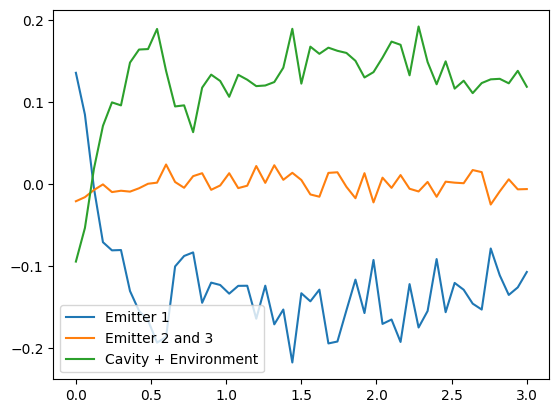

In [13]:
for col, bitstr in jaqal_normed_bitstrs.items():
    diff = qutip_results[col] - np.array(jaqal_results_norm[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms["jaqal normed"][col] = np.sqrt(np.sum(diff**2))
    mae["jaqal normed"][col] = np.mean(np.abs(diff))
    plt.plot(times, diff, label=col)

plt.legend()

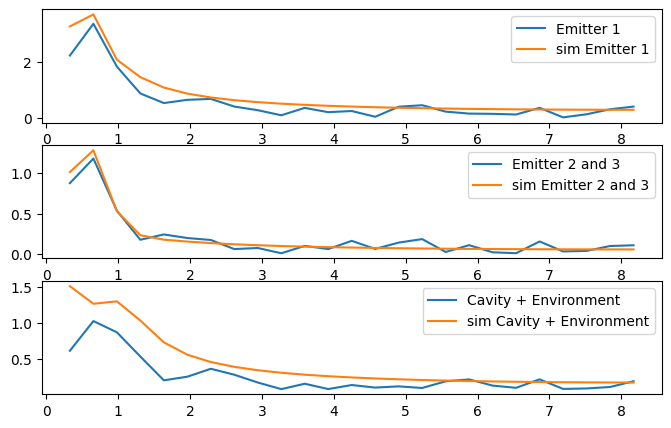

In [14]:
n = len(jaqal_results)
fig, axes = plt.subplots(3, 1, figsize=(8, 5))

for (col, bitstr), ax in zip(jaqal_normed_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(jaqal_results_norm[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label="sim " + col)

    ax.legend()

# SUPERSTAQ compiled

In [15]:
superstaq_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0010",
    "Cavity + Environment": "0001",
}

Emitter 1 RMS 0.7659728729022024
Emitter 2 RMS 0.30473179889369634
Emitter 3 RMS 0.31833844694216573
Cavity + Environment RMS 0.5099144286086992


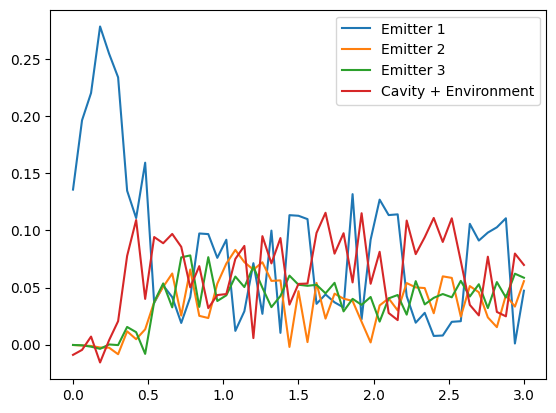

In [16]:
for col, bitstr in superstaq_bitstrs.items():
    diff = qutip_results[col] - np.array(superstaq_results[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms["superstaq"][col] = np.sqrt(np.sum(diff**2))
    mae["superstaq"][col] = np.mean(np.abs(diff))
    plt.plot(times, diff, label=col)

em23_mean = 0.5 * (np.array(superstaq_results[superstaq_bitstrs["Emitter 2"]]) + np.array(superstaq_results[superstaq_bitstrs["Emitter 3"]]))
diff = qutip_results[col] - em23_mean
superstaq_em23 = np.mean(np.abs(diff))

plt.legend()

## fourier

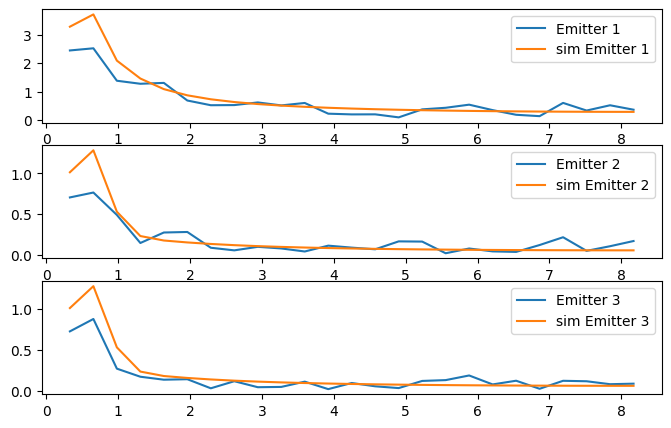

In [17]:
n = len(superstaq_results)
fig, axes = plt.subplots(3, 1, figsize=(8, 5))

for (col, bitstr), ax in zip(superstaq_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(superstaq_results[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label="sim " + col)

    ax.legend()

## normalized and averaged

In [18]:
superstaq_normed_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2 and 3": "avg_0100_0010",
    "Cavity + Environment": "0001",
}

In [19]:
superstaq_results_norm = superstaq_results.copy()
superstaq_results_norm[['1000', '0100', '0010', '0001']] = superstaq_results_norm[['1000', '0100', '0010', '0001']].divide(superstaq_results_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
superstaq_results_norm['avg_0100_0010'] = superstaq_results_norm[['0100', '0010']].mean(axis=1)

Emitter 1 RMS 0.4295665243147263
Emitter 2 and 3 RMS 0.16666981515383059
Cavity + Environment RMS 0.27265307428910496


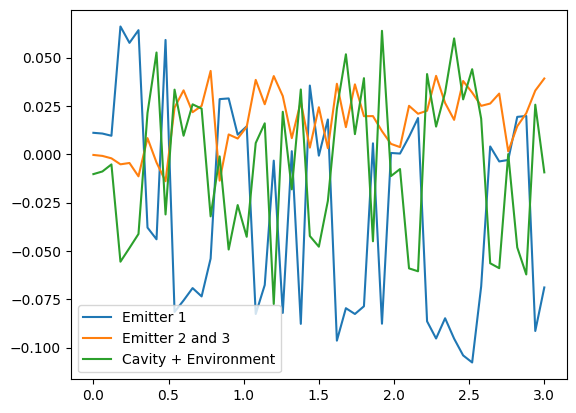

In [20]:
for col, bitstr in superstaq_normed_bitstrs.items():
    diff = qutip_results[col] - np.array(superstaq_results_norm[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms["superstaq normed"][col] = np.sqrt(np.sum(diff**2))
    mae["superstaq normed"][col] = np.mean(np.abs(diff))
    plt.plot(times, diff, label=col)

plt.legend()

## fourier

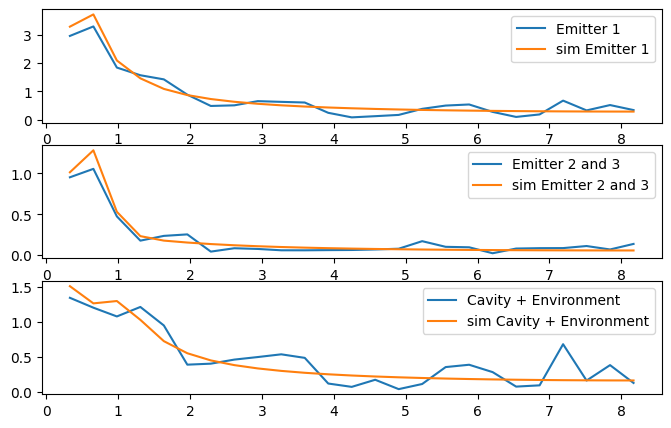

In [21]:
n = len(superstaq_results_norm)
fig, axes = plt.subplots(3, 1, figsize=(8, 5))

for (col, bitstr), ax in zip(superstaq_normed_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(superstaq_results_norm[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label="sim " + col)

    ax.legend()

# Mirror swaps

In [22]:
mirror_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0010",
    "Cavity + Environment": "0001",
}

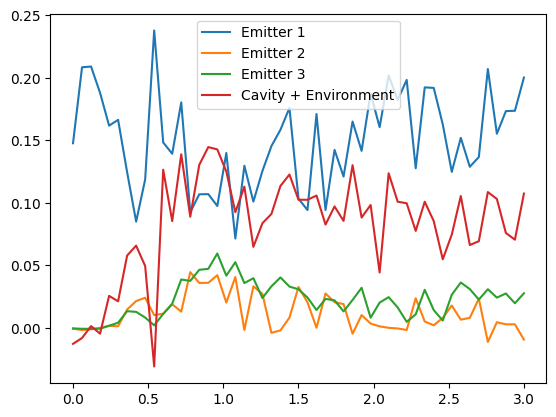

In [23]:
for col, bitstr in mirror_bitstrs.items():
    diff = qutip_results[col] - np.array(mirror_results[bitstr])
    # print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms["mirror swaps"][col] = np.sqrt(np.sum(diff**2))
    mae["mirror swaps"][col] = np.mean(np.abs(diff))
    plt.plot(times, diff, label=col)

em23_mean = 0.5 * (np.array(mirror_results[mirror_bitstrs["Emitter 2"]]) + np.array(mirror_results[mirror_bitstrs["Emitter 3"]]))
diff = qutip_results[col] - em23_mean
mirror_swap_em23 = np.mean(np.abs(diff))

plt.legend()

## fourier

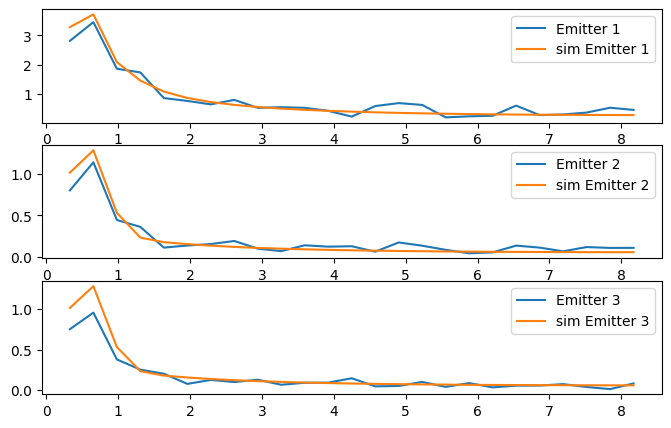

In [24]:
n = len(mirror_results)
fig, axes = plt.subplots(3, 1, figsize=(8, 5))

for (col, bitstr), ax in zip(mirror_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(mirror_results[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label="sim " + col)

    ax.legend()

## normed

In [25]:
mirror_normed_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2 and 3": "avg_0100_0010",
    "Cavity + Environment": "0001",
}

In [26]:
mirror_results_norm = mirror_results.copy()
mirror_results_norm[['1000', '0100', '0010', '0001']] = mirror_results_norm[['1000', '0100', '0010', '0001']].divide(mirror_results_norm[['1000', '0100', '0010', '0001']].sum(axis=1), axis=0)
mirror_results_norm['avg_0100_0010'] = mirror_results_norm[['0100', '0010']].mean(axis=1)

Emitter 1 RMS 0.36154558325611597
Emitter 2 and 3 RMS 0.17045187330843403
Cavity + Environment RMS 0.20932943855409858


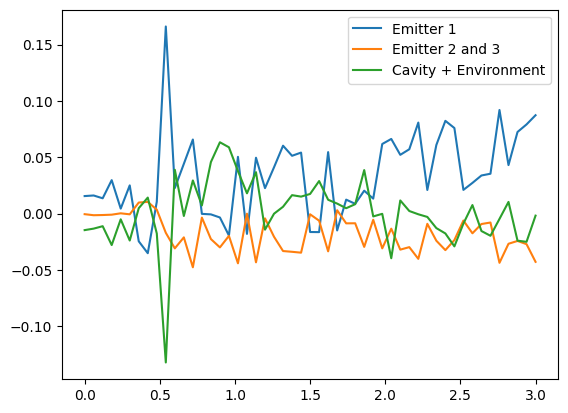

In [27]:
for col, bitstr in mirror_normed_bitstrs.items():
    diff = qutip_results[col] - np.array(mirror_results_norm[bitstr])
    print(col, "RMS", np.sqrt(np.sum(diff**2)))
    rms["mirror swaps normed"][col] = np.sqrt(np.sum(diff**2))
    mae["mirror swaps normed"][col] = np.mean(np.abs(diff))
    plt.plot(times, diff, label=col)

plt.legend()

## fourier

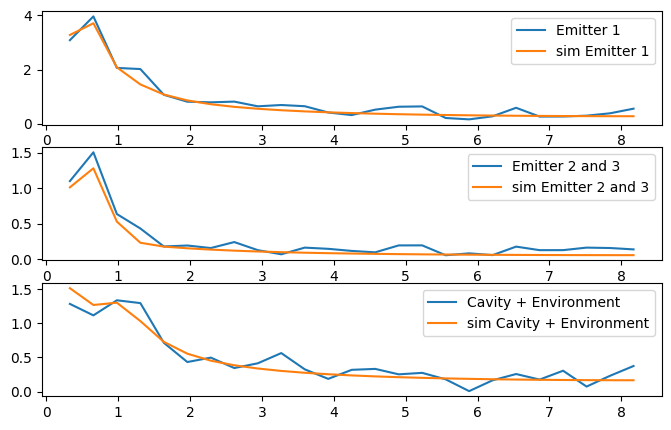

In [28]:
n = len(mirror_results_norm)
fig, axes = plt.subplots(3, 1, figsize=(8, 5))

for (col, bitstr), ax in zip(mirror_normed_bitstrs.items(), axes.flatten()):
    fft = np.fft.rfft(mirror_results_norm[bitstr], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label=col)

    fft = np.fft.rfft(qutip_results[col], n)
    freqs = np.fft.rfftfreq(n, times[1] - times[0])
    ax.plot(freqs[1:], np.abs(fft)[1:], label="sim " + col)

    ax.legend()

/var/folders/ds/t6zgkw3n75d3gzz89xmkcncm0000gn/T/ipykernel_80224/2466252978.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


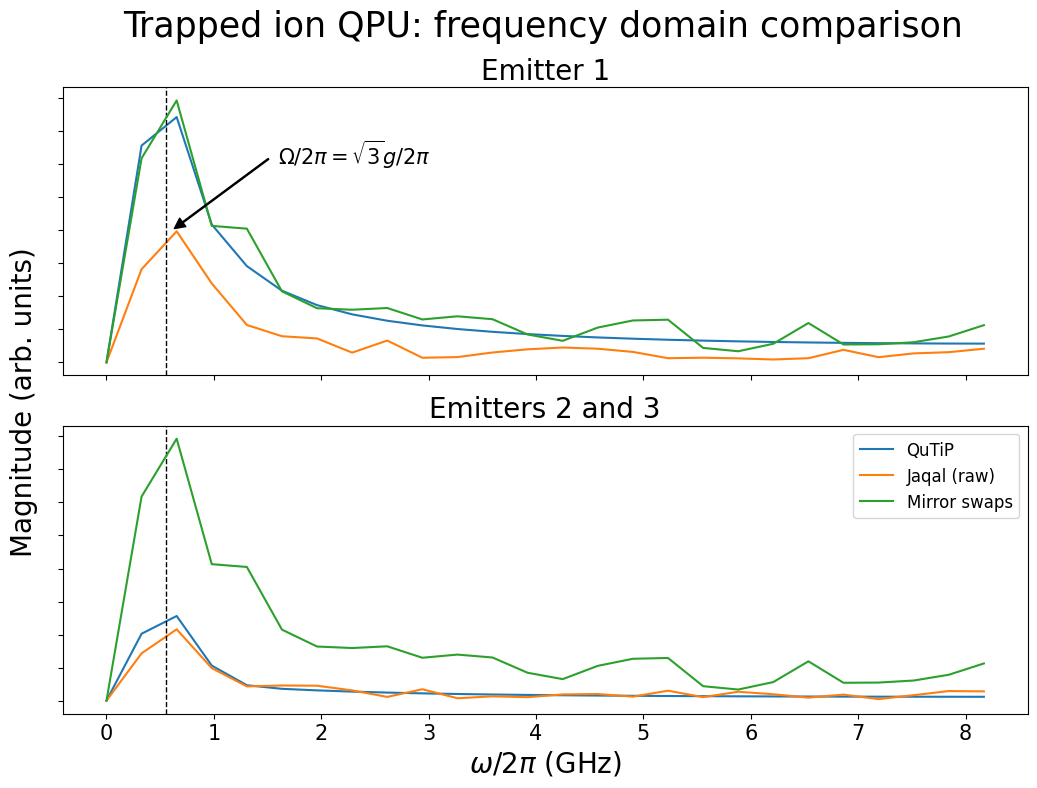

In [54]:
# Paper fourier for AQT
rabi_freq = np.sqrt(3) * g / (2*np.pi)

n = len(jaqal_results_norm)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

freqs = np.fft.rfftfreq(n, times[1] - times[0])

##
em1_fft_qt = np.abs(np.fft.rfft(qutip_results["Emitter 1"] - qutip_results["Emitter 1"].mean(), n))
axes[0].plot(freqs, em1_fft_qt, label="QuTiP")

em1_fft = np.abs(np.fft.rfft(jaqal_results[jaqal_bitstrs["Emitter 1"]] - jaqal_results[jaqal_bitstrs["Emitter 1"]].mean(), n))
axes[0].plot(freqs, em1_fft)

axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_title("Emitter 1", fontsize=20)
axes[0].axvline(rabi_freq, lw=1, color='black', linestyle='--')

##

em23_fft = np.abs(np.fft.rfft(qutip_results["Emitter 2"] - qutip_results["Emitter 2"].mean(), n))
axes[1].plot(freqs, em23_fft, label="QuTiP")

em23_fft = np.abs(np.fft.rfft(jaqal_results[jaqal_bitstrs["Emitter 2"]] - jaqal_results[jaqal_bitstrs["Emitter 2"]].mean(), n))
axes[1].plot(freqs, em23_fft, label="Jaqal (raw)")

axes[1].tick_params(axis='x', labelsize=15)
axes[1].set_yticklabels([])
axes[1].set_title("Emitters 2 and 3", fontsize=20)
axes[1].axvline(rabi_freq, lw=1, color='black', linestyle='--')


### nox on lower row
em1_fft_nox = np.abs(np.fft.rfft(mirror_results_norm[mirror_normed_bitstrs["Emitter 1"]] - mirror_results_norm[mirror_normed_bitstrs["Emitter 1"]].mean(), n))
axes[0].plot(freqs, em1_fft_nox, label="Mirror swaps")

em23_fft_nox = np.abs(np.fft.rfft(mirror_results_norm[mirror_normed_bitstrs["Emitter 1"]] - mirror_results_norm[mirror_normed_bitstrs["Emitter 1"]].mean(), n))
axes[1].plot(freqs, em23_fft_nox, label="Mirror swaps")



# axes[0].set_xlabel(r"$\omega / 2\pi$ (GHz)", fontsize=20)
axes[1].set_xlabel(r"$\omega / 2\pi$ (GHz)", fontsize=20)


##
fig.text(-0.04, 0.45, "Magnitude (arb. units)", transform=axes[0].transAxes,
        ha='center', va='top', fontsize=20, rotation=90)
##
axes[0].annotate(
    r'$\Omega/2\pi = \sqrt{3}g/2\pi$', # the text of the annotation
    fontsize=15,
    xy=(rabi_freq + 0.06, 2),       # the point (x,y) to annotate
    xytext=(1.6, 3),   # the position of the text (x,y)
    arrowprops=dict(
        arrowstyle="simple, tail_width=0.05, head_width=.5, head_length=.5",
        connectionstyle="arc3",  # connection style
        facecolor='black',
        relpos=(-0.05, 0.4),
    )
)
##

fig.suptitle("Trapped ion QPU: frequency domain comparison", fontsize=25)
plt.legend(fontsize=12)
plt.tight_layout()
fig.show()

In [55]:
fig.savefig("../../figures/QSCOUT_fourier.eps", bbox_inches="tight")

In [31]:
all_rms = pd.DataFrame.from_dict(rms, orient="index")
all_rms

,Emitter 1,Emitter 2,Emitter 3,Cavity + Environment,Emitter 2 and 3
jaqal,0.964633,0.128683,0.481097,1.361410,NaN
jaqal normed,0.991830,NaN,NaN,0.961852,0.084042
superstaq,0.765973,0.304732,0.318338,0.509914,NaN
superstaq normed,0.429567,NaN,NaN,0.272653,0.166670
mirror swaps,1.105818,0.132434,0.194402,0.656127,NaN
mirror swaps normed,0.361546,NaN,NaN,0.209329,0.170452


In [32]:
all_mae = pd.DataFrame.from_dict(mae, orient="index")
all_mae

,Emitter 1,Emitter 2,Emitter 3,Cavity + Environment,Emitter 2 and 3
jaqal,0.084228,0.015266,0.060489,0.184573,NaN
jaqal normed,0.133256,NaN,NaN,0.130352,0.009604
superstaq,0.084637,0.035980,0.039678,0.062972,NaN
superstaq normed,0.048757,NaN,NaN,0.032885,0.019739
mirror swaps,0.150120,0.013458,0.023001,0.084397,NaN
mirror swaps normed,0.040235,NaN,NaN,0.019821,0.019024


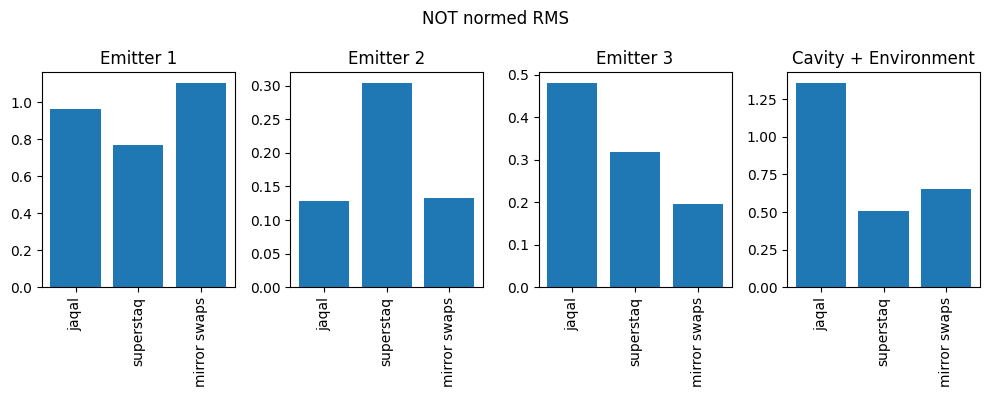

In [33]:
# NOT normed RMS
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

not_norm_rows = [r for r in all_rms.index if 'norm' not in r]
not_norm_rms = all_rms.loc[not_norm_rows]

for col, ax in zip(superstaq_bitstrs, axes.flatten()):
    ax.bar(not_norm_rms.index, not_norm_rms[col])
    
    ax.set_xticks(np.arange(len(not_norm_rms.index)))
    ax.set_xticklabels(not_norm_rms.index, rotation=90)

    ax.set_title(col)

fig.suptitle("NOT normed RMS")
plt.tight_layout()

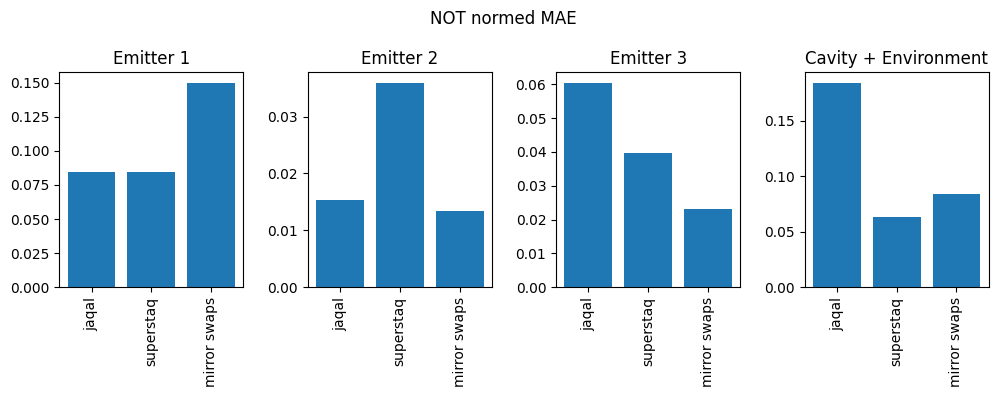

In [34]:
# NOT normed MAE
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

not_norm_rows = [r for r in all_mae.index if 'norm' not in r]
not_norm_mae = all_mae.loc[not_norm_rows]

for col, ax in zip(superstaq_bitstrs, axes.flatten()):
    ax.bar(not_norm_mae.index, not_norm_mae[col])
    
    ax.set_xticks(np.arange(len(not_norm_mae.index)))
    ax.set_xticklabels(not_norm_mae.index, rotation=90)

    ax.set_title(col)

fig.suptitle("NOT normed MAE")
plt.tight_layout()

In [35]:
all_mae

,Emitter 1,Emitter 2,Emitter 3,Cavity + Environment,Emitter 2 and 3
jaqal,0.084228,0.015266,0.060489,0.184573,NaN
jaqal normed,0.133256,NaN,NaN,0.130352,0.009604
superstaq,0.084637,0.035980,0.039678,0.062972,NaN
superstaq normed,0.048757,NaN,NaN,0.032885,0.019739
mirror swaps,0.150120,0.013458,0.023001,0.084397,NaN
mirror swaps normed,0.040235,NaN,NaN,0.019821,0.019024


In [36]:
norm_rows = ["jaqal"] + [r for r in all_mae.index if 'norm' in r]
norm_mae = all_mae.loc[norm_rows]
norm_mae.loc["jaqal", "Emitter 2 and 3"] = jaqal_23_mean_mae
norm_mae.loc["superstaq"] = all_mae.loc["superstaq"]
norm_mae.loc["mirror swaps"] = all_mae.loc["mirror swaps"]
rows = [
    "jaqal",
    "jaqal normed",
    "superstaq",
    "superstaq normed",
    "mirror swaps",
    "mirror swaps normed",
]
norm_mae.loc["superstaq", "Emitter 2 and 3"] = superstaq_em23
norm_mae.loc["mirror swaps", "Emitter 2 and 3"] = mirror_swap_em23
norm_mae = norm_mae.loc[rows, :]

In [37]:
norm_mae

,Emitter 1,Emitter 2,Emitter 3,Cavity + Environment,Emitter 2 and 3
jaqal,0.084228,0.015266,0.060489,0.184573,0.226574
jaqal normed,0.133256,NaN,NaN,0.130352,0.009604
superstaq,0.084637,0.035980,0.039678,0.062972,0.228392
superstaq normed,0.048757,NaN,NaN,0.032885,0.019739
mirror swaps,0.150120,0.013458,0.023001,0.084397,0.208670
mirror swaps normed,0.040235,NaN,NaN,0.019821,0.019024


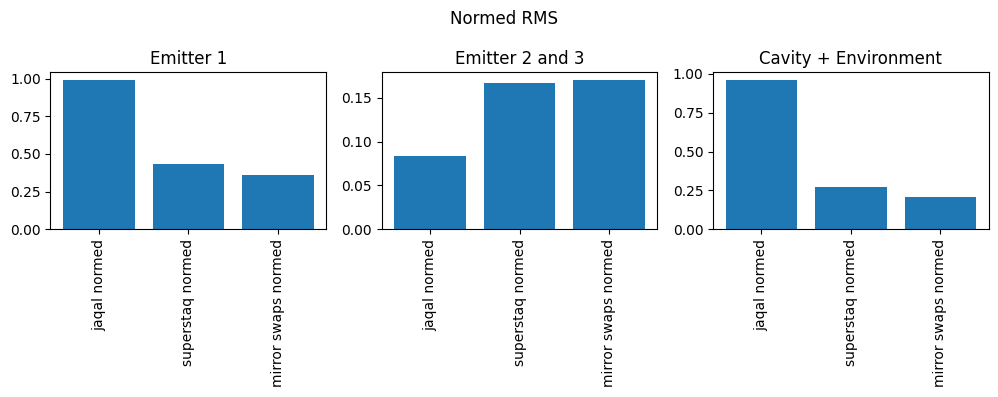

In [38]:
# normed RMS
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

norm_rows = [r for r in all_rms.index if 'norm' in r]
norm_rms = all_rms.loc[norm_rows]

for col, ax in zip(superstaq_normed_bitstrs, axes.flatten()):
    ax.bar(norm_rms.index, norm_rms[col])
    
    ax.set_xticks(np.arange(len(norm_rms.index)))
    ax.set_xticklabels(norm_rms.index, rotation=90)

    ax.set_title(col)

fig.suptitle("Normed RMS")
plt.tight_layout()

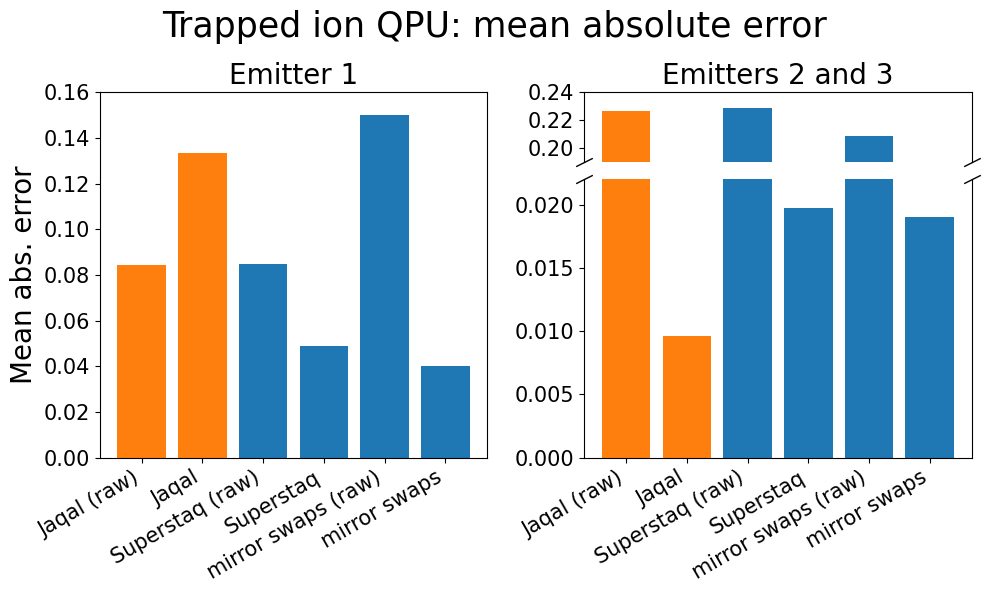

In [48]:
# normed MAE
import matplotlib.gridspec as gridspec

# norm_rows = ["jaqal"] + [r for r in all_mae.index if 'norm' in r]
# norm_mae = all_mae.loc[norm_rows]
# norm_mae.loc["jaqal", "Emitter 2 and 3"] = jaqal_23_mean_mae

colors = ["tab:orange"] * 2 + ["tab:blue"] * 4


fig = plt.figure(figsize=(10, 6))

gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1,4])

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

ax1.bar(norm_mae.index, norm_mae["Emitter 1"], color=colors)
ax1.set_xticks([0,1,2,3,4,5])
ax1.set_xticklabels(["Jaqal (raw)", "Jaqal", "Superstaq (raw)", "Superstaq", "mirror swaps (raw)", "mirror swaps"], ha='right', rotation=30)
ax1.set_ylabel("Mean abs. error", fontsize=20)
ax1.set_title("Emitter 1", fontsize=20)
ax1.tick_params(axis='x', labelsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16])

ax2.spines.bottom.set_visible(False)
ax2.set_xticks([])
ax3.spines.top.set_visible(False)


ax2.bar(norm_mae.index, norm_mae["Emitter 2 and 3"], color=colors)
ax2.set_ylim(0.19, 0.24)
ax2.set_yticks([0.2, 0.22, 0.24])
ax2.tick_params(axis='y', labelsize=15)
ax2.set_title("Emitters 2 and 3", fontsize=20)

ax3.bar(norm_mae.index, norm_mae["Emitter 2 and 3"], color=colors)
ax3.set_xticks([0,1,2,3,4,5])
ax3.set_xticklabels(["Jaqal (raw)", "Jaqal", "Superstaq (raw)", "Superstaq", "mirror swaps (raw)", "mirror swaps"], ha='right', rotation=30)
ax3.set_ylim(0, 0.022)
ax3.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
ax3.tick_params(axis='x', labelsize=15)
ax3.tick_params(axis='y', labelsize=15)

fig.suptitle("Trapped ion QPU: mean absolute error", fontsize=25)

d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2.plot([0, 1], [0, 0], transform=ax2.transAxes, **kwargs)
ax3.plot([0, 1], [1, 1], transform=ax3.transAxes, **kwargs)

plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.25)

In [49]:
fig.savefig("../../figures/QSCOUT_mean_abs_error.eps", bbox_inches="tight")

In [41]:
a = np.pi * 5e-3**2
20e-3 / a

254.64790894703256

In [42]:
not_norm_rms.sum(axis=1)

jaqal           2.935823
superstaq       1.898958
mirror swaps    2.088781
dtype: float64

In [43]:
norm_rms.sum(axis=1)

jaqal normed           2.037723
superstaq normed       0.868889
mirror swaps normed    0.741327
dtype: float64

In [44]:
not_norm_mae.sum(axis=1)

jaqal           0.344556
superstaq       0.223266
mirror swaps    0.270976
dtype: float64

In [45]:
norm_mae.sum(axis=1)

jaqal                  0.571130
jaqal normed           0.273212
superstaq              0.451659
superstaq normed       0.101381
mirror swaps           0.479646
mirror swaps normed    0.079079
dtype: float64